In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import sys
sys.path.append(os.path.abspath('../'))
import utils.dataset_loader as dl
import utils.analysis as analysis
import utils.compute as compute

In [2]:
# Paths 
DATASETS_PATH = '../datasets'


In [3]:
# Dataset paths
datasets = {
    "random_dataset": "random_dataset",
}

In [4]:
# Load all datasets with caching
loaded_datasets = {
    name: dl.load_dataset_files_with_cache(path, cache_path=f"{DATASETS_PATH}/cache/{name}_cache.pkl")
    for name, path in datasets.items()
}

Checking for cache at: ../datasets/cache/random_dataset_cache.pkl
Loading datasets from cache: ../datasets/cache/random_dataset_cache.pkl


In [5]:
PRESENT_SBOX = np.array([
    12,5,6,11,9,0,10,13,3,14,15,8,4,7,1,2
], dtype=np.uint8)


### Hypothesis
We hypothesize that the power consumption traces recorded during PRESENT encryption contain
statistically significant leakage points that correlate with cryptographic intermediate values.
To validate this, we will analyze the traces using two techniques:
- **Signal-to-Noise Ratio (SNR)** grouped by SBox output
- **Pearson correlation** with the Hamming weight of the SBox output


In [6]:
def convert_to_hex_string_array(array):
    result = []
    for item in array:
        hex_str = str(item[0])
        nibbles = [int(c, 16) for c in hex_str]
        result.append(nibbles)
    return np.array(result, dtype=np.uint8)

In [7]:
# Load the dataset
random_dataset = loaded_datasets['random_dataset']

# Get the trace matrix
traces = dl.get_trace_matrix(random_dataset)  # shape (n_traces, n_samples)

# Get plaintexts and keys
plaintexts_values = random_dataset['plaintexts'].values
keys_values = random_dataset['keys'].values

# Convert hex strings to nibble arrays
plaintexts = convert_to_hex_string_array(plaintexts_values)
keys = convert_to_hex_string_array(keys_values)

In [8]:
nibble_idx = 0  # 0 to 15

pt_nibble = plaintexts[:, nibble_idx] & 0xF
key_nibble = keys[:, nibble_idx] & 0xF


sbox_inputs = pt_nibble ^ key_nibble
sbox_outputs = PRESENT_SBOX[sbox_inputs]


In [9]:
sbox_inputs

array([ 8,  0, 10, ...,  3,  3, 14], dtype=uint8)

In [10]:
sbox_outputs

array([ 3, 12, 15, ..., 11, 11,  1], dtype=uint8)

In [11]:
sbox_outputs_x = compute._present_sbox_output_nibble(plaintexts, keys, 0, PRESENT_SBOX)

In [12]:
sbox_outputs_x

array([ 3, 12, 15, ..., 11, 11,  1], dtype=uint8)

In [13]:
# Allocate array to hold SBox outputs for each nibble
sbox_outputs = np.zeros(16, dtype=np.uint8)
plaintext = plaintexts[0]
key = keys[0]
print("Index | PT  | KEY | XOR | SBOX_IN | SBOX_OUT")
print("----------------------------------------------")
for i in range(16):
    pt_nib = plaintext[i] & 0xF
    key_nib = key[i] & 0xF
    sbox_in = pt_nib ^ key_nib
    sbox_out = PRESENT_SBOX[sbox_in]
    sbox_outputs[i] = sbox_out
    
    print(f"  {i:2}   | {pt_nib:2}  | {key_nib:3} | {pt_nib ^ key_nib:3} |    {sbox_in:3}   |    {sbox_out:3}")

print("\nSBox output per nibble:", sbox_outputs)

Index | PT  | KEY | XOR | SBOX_IN | SBOX_OUT
----------------------------------------------
   0   | 14  |   6 |   8 |      8   |      3
   1   |  8  |   5 |  13 |     13   |      7
   2   | 14  |  13 |   3 |      3   |     11
   3   | 13  |   9 |   4 |      4   |      9
   4   |  1  |  10 |  11 |     11   |      8
   5   | 14  |  10 |   4 |      4   |      9
   6   |  1  |  13 |  12 |     12   |      4
   7   |  4  |   5 |   1 |      1   |      5
   8   |  0  |   5 |   5 |      5   |      0
   9   |  8  |  12 |   4 |      4   |      9
  10   |  7  |   6 |   1 |      1   |      5
  11   | 12  |  12 |   0 |      0   |     12
  12   |  1  |   6 |   7 |      7   |     13
  13   |  4  |  12 |   8 |      8   |      3
  14   |  1  |  14 |  15 |     15   |      2
  15   |  4  |   7 |   3 |      3   |     11

SBox output per nibble: [ 3  7 11  9  8  9  4  5  0  9  5 12 13  3  2 11]


In [14]:
traces

array([[-0.01757812, -0.08105469,  0.13085938, ..., -0.15820312,
        -0.09375   ,  0.04882812],
       [-0.01855469, -0.078125  ,  0.13085938, ..., -0.15722656,
        -0.09375   ,  0.04882812],
       [-0.01660156, -0.07714844,  0.12695312, ..., -0.15527344,
        -0.08691406,  0.04980469],
       ...,
       [-0.01953125, -0.08105469,  0.13085938, ..., -0.15527344,
        -0.09082031,  0.04882812],
       [-0.015625  , -0.07714844,  0.12890625, ..., -0.15527344,
        -0.08984375,  0.04589844],
       [-0.01660156, -0.078125  ,  0.12988281, ..., -0.15722656,
        -0.09082031,  0.046875  ]])

In [15]:
plaintexts

array([[14,  8, 14, ...,  4,  1,  4],
       [13, 12,  6, ...,  9, 10,  5],
       [ 8,  9,  3, ..., 15,  8,  7],
       ...,
       [ 5,  1,  8, ...,  5,  6,  0],
       [12,  0,  5, ...,  7, 11, 13],
       [ 7,  1, 13, ...,  8,  0, 11]], dtype=uint8)

In [16]:
keys

array([[ 6,  5, 13, ..., 12, 14,  7],
       [13,  8, 12, ...,  5,  6, 13],
       [ 2,  2, 15, ..., 13, 15, 13],
       ...,
       [ 6, 11, 10, ..., 13, 13,  7],
       [15, 11,  0, ..., 14, 12,  5],
       [ 9, 14, 12, ...,  6,  6,  1]], dtype=uint8)

In [17]:
sbox_outputs = compute._present_sbox_output_nibble(plaintexts, keys, nibble_idx=0, PRESENT_SBOX=PRESENT_SBOX)

In [18]:
snr = compute._snr(traces, sbox_outputs, num_classes=16)

In [19]:
correlation = compute._correlation(traces, sbox_outputs)


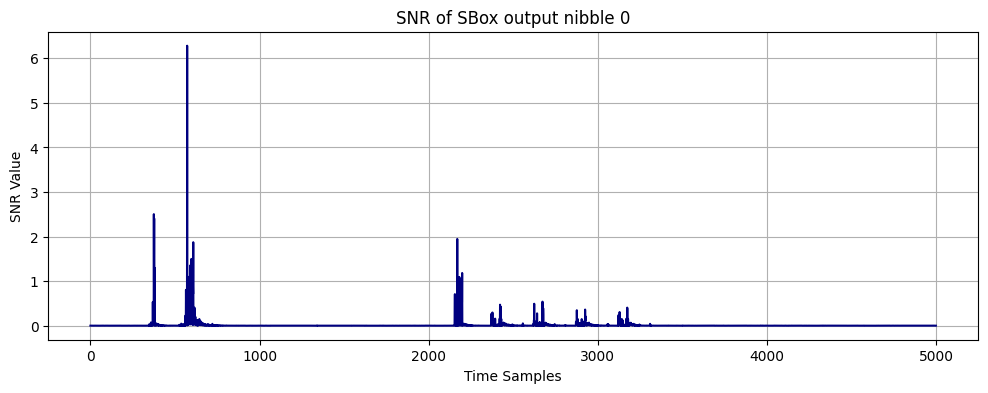

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(snr, color='navy')
plt.title("SNR of SBox output nibble 0")
plt.xlabel("Time Samples")
plt.ylabel("SNR Value")
plt.grid(True)
plt.show()

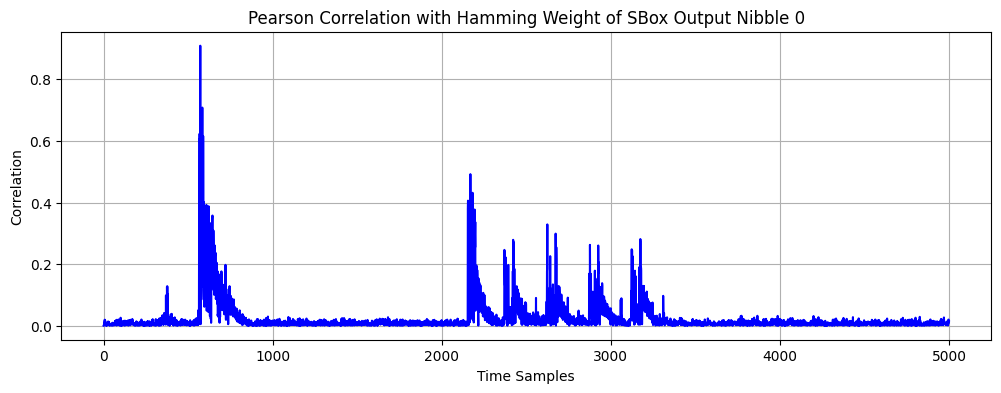

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(correlation, label='Correlation with HW(SBox output)', color='blue')
plt.title('Pearson Correlation with Hamming Weight of SBox Output Nibble 0')
plt.xlabel('Time Samples')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

In [37]:
top_pois_snr = np.where(snr > 0.7)[0]
print("Top Points of Interest (sample indices):", top_pois_snr)

Top Points of Interest (sample indices): [ 375  376  377  380  565  568  572  584  586  589  590  597  606  607
  608 2155 2169 2181 2182 2186 2194 2198]


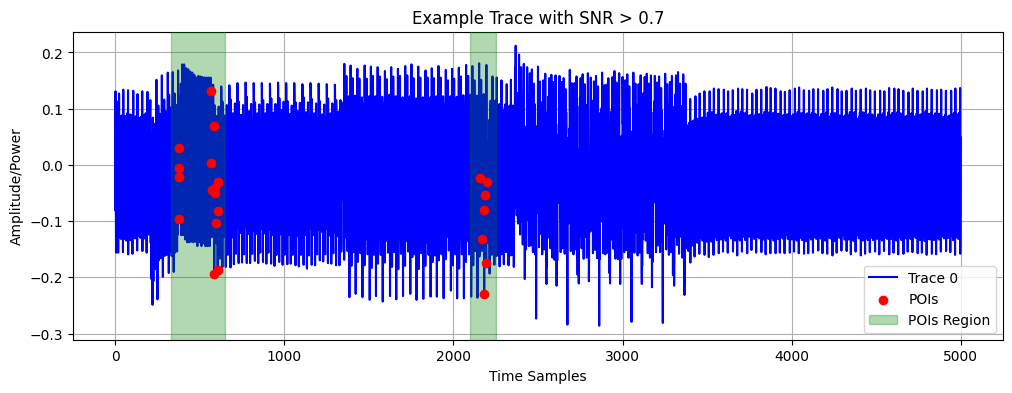

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(traces[0], label="Trace 0", color='blue')
plt.scatter(top_pois_snr, traces[0][top_pois_snr], color='red', label="POIs", zorder=4)
plt.title("Example Trace with SNR > 0.7")
plt.ylabel('Amplitude/Power')
plt.xlabel('Time Samples')
plt.axvspan(330, 650, color='green', alpha=0.3, label="POIs Region", zorder=3)
plt.axvspan(2100, 2250, color='green', alpha=0.3, zorder=3)
plt.legend()
plt.grid(True)
plt.show()

In [40]:
top_pois_corr_hw = np.where(correlation > 0.3)[0]  # Top POIs
print("Top Points of Interest HW(sample indices):", top_pois_corr_hw)

Top Points of Interest HW(sample indices): [ 565  568  570  571  572  577  582  583  584  585  586  588  589  590
  593  597  598  606  608  617  619  621  631  633  643  644  649  650
 2154 2155 2157 2159 2169 2171 2181 2182 2186 2194 2196 2198 2624]


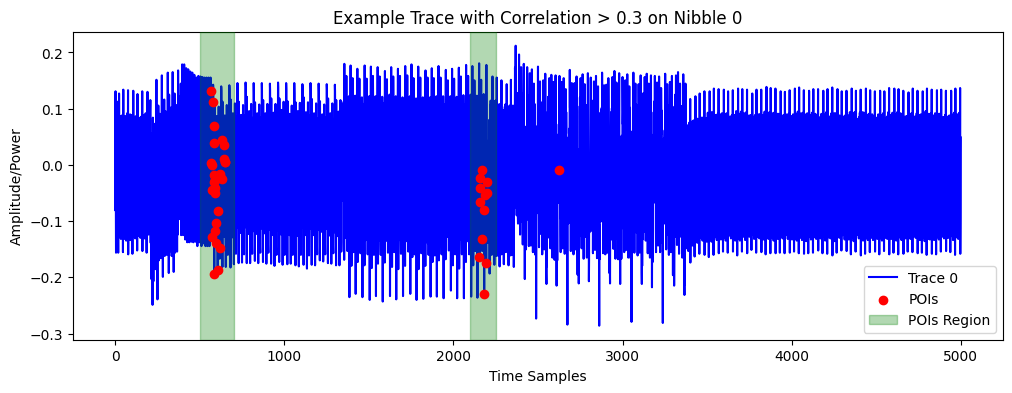

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(traces[0], label="Trace 0", color='blue')
plt.scatter(top_pois_corr_hw, traces[0][top_pois_corr_hw], color='red', label="POIs", zorder=5)
plt.title("Example Trace with Correlation > 0.3 on Nibble 0")
plt.ylabel('Amplitude/Power')
plt.xlabel('Time Samples')
plt.axvspan(500, 700, color='green', alpha=0.3, label="POIs Region", zorder=3)
plt.axvspan(2100, 2250, color='green', alpha=0.3, zorder=3)
plt.legend()
plt.show()

In [26]:
results_present = analysis.analyze_leakage_all_nibbles(traces, plaintexts, keys, PRESENT_SBOX, top_k=3, is_nibble_level=True)



 Analyzing nibble 0...


  Top SNR POIs: [572 375 377], values: [6.28312759 2.50355011 2.40705213]
  Top Corr POIs: [572 584 568], values: [0.90895114 0.7080482  0.62325992]

 Analyzing nibble 1...
  Top SNR POIs: [ 560  368 2144], values: [4.97607543 3.82964523 1.73925088]
  Top Corr POIs: [560 632 637], values: [0.89500458 0.63555289 0.63392057]

 Analyzing nibble 2...
  Top SNR POIs: [ 548  356 2061], values: [4.48524609 3.87019596 2.79607355]
  Top Corr POIs: [548 685 680], values: [0.88240143 0.64292466 0.62013613]

 Analyzing nibble 3...
  Top SNR POIs: [ 536 2012  752], values: [3.50103104 2.25993033 1.95273617]
  Top Corr POIs: [536 733 728], values: [0.8681218  0.64387309 0.56251742]

 Analyzing nibble 4...
  Top SNR POIs: [ 524  333 1981], values: [5.4984888  4.31438207 2.84081461]
  Top Corr POIs: [524 776 781], values: [0.89015076 0.71493893 0.65360226]

 Analyzing nibble 5...
  Top SNR POIs: [ 512  321 1904], values: [4.71622378 4.45381863 2.45996476]
  Top Corr POIs: [512 829 824], values: [0.877

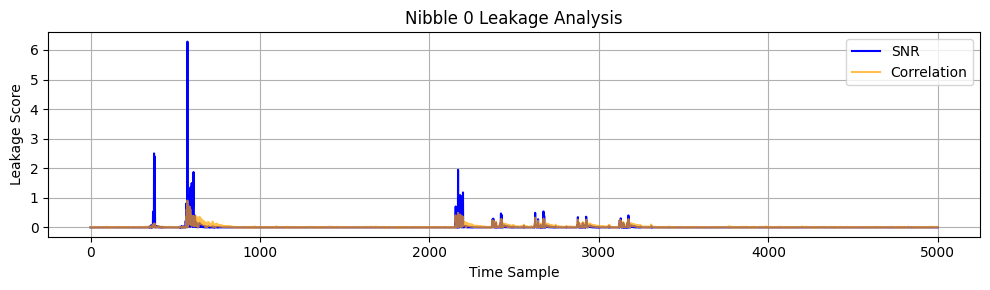

In [27]:
for nibble in range(1):
    plt.figure(figsize=(10, 3))
    plt.plot(results_present[nibble]['snr'], label='SNR', color='blue')
    plt.plot(results_present[nibble]['correlation'], label='Correlation', color='orange', alpha=0.7)
    plt.title(f'Nibble {nibble} Leakage Analysis')
    plt.xlabel('Time Sample')
    plt.ylabel('Leakage Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


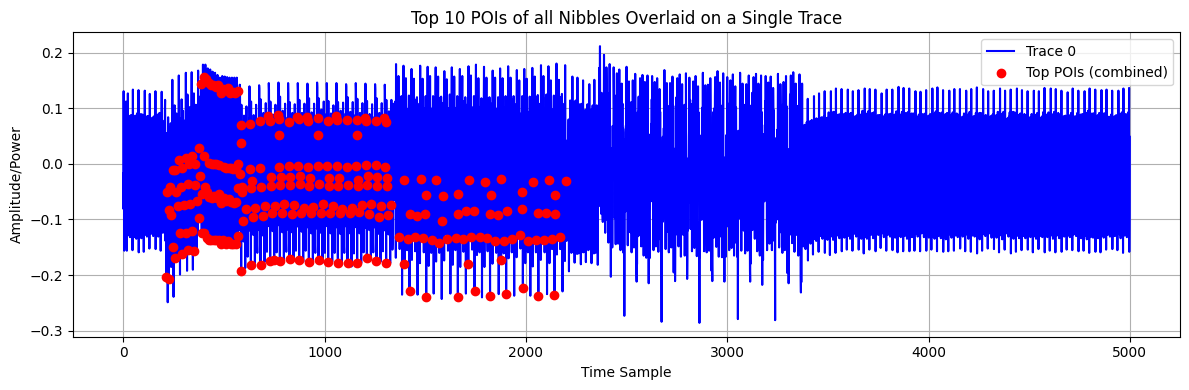

In [28]:
# Choose one trace to highlight POIs on
trace_index = 0
trace = traces[trace_index]

# Collect all top 3 POIs from each nibble's SNR
poi_indices = []
for nibble in range(16):
    # top_pois_snr = np.where(results_present[nibble]['snr'] > 0.7)[0]
    # top_pois_corr = np.where(results_present[nibble]['correlation'] > 0.9)[0]
    top_pois_snr = np.argsort(results_present[nibble]['snr'])[-10:]  # Top 10
    top_pois_corr = np.argsort(results_present[nibble]['correlation'])[-10:]  # Top 10
    poi_indices.extend(top_pois_snr)
    poi_indices.extend(top_pois_corr)

# Remove duplicates and sort
poi_indices = sorted(set(poi_indices))

# Plot the trace
plt.figure(figsize=(12, 4))
plt.plot(trace, label=f"Trace {trace_index}", color='blue')

# Mark POIs
plt.scatter(poi_indices, trace[poi_indices], color='red', zorder=5, label="Top POIs (combined)")
plt.title("Top 10 POIs of all Nibbles Overlaid on a Single Trace")
plt.xlabel("Time Sample")
plt.ylabel("Amplitude/Power")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
def export_sbox_and_labels_per_nibble(sbox_outputs, dataset_name="present", base_dir="../dataset"):
    """
    Save cropped traces and SBox labels to a structured directory.
    Also saves per-nibble label arrays.

    Parameters:
        cropped_traces (np.ndarray): shape (n_traces, n_samples)
        sbox_outputs (np.ndarray): shape (n_traces, 16)
        dataset_name (str): name of subfolder to store data
        base_dir (str): root dataset directory (default: "dataset")
    """
    output_dir = os.path.join(base_dir, dataset_name)
    os.makedirs(output_dir, exist_ok=True)

    # Save full label matrix
    np.save(os.path.join(output_dir, "sbox_outputs.npy"), sbox_outputs)

    # Save one label file per nibble
    for nibble in range(sbox_outputs.shape[1]):
        nibble_labels = sbox_outputs[:, nibble]
        nibble_path = os.path.join(output_dir, f"nibble_{nibble}_labels.npy")
        np.save(nibble_path, nibble_labels)

    print(f"Exported labels (with per-nibble files) to: {output_dir}")


In [30]:
sbox_outputs = compute._present_sbox_outputs(plaintexts, keys, PRESENT_SBOX)

In [31]:
export_sbox_and_labels_per_nibble(sbox_outputs, dataset_name="present")

Exported labels (with per-nibble files) to: ../dataset/present


In [32]:

global_pois = []

for nibble_idx in range(16):

    poi_indices = []

    # High leakegeage nibbles
    # snr_top = np.where(results_present[nibble_idx]['snr'] > 0.7)[0]
    # hw_top = np.where(results_present[nibble_idx]['correlation'] > 0.9)[0]

    snr_top = np.argsort(results_present[nibble_idx]['snr'])[-25:]
    hw_top = np.argsort(results_present[nibble_idx]['correlation'])[-40:]

    poi_indices.extend(snr_top)
    poi_indices.extend(hw_top)

    global_pois.extend(poi_indices)

    unique_pois = sorted(set(poi_indices))
    
    filename = f"../dataset/present/pois/nibble_{nibble_idx}_pois.npy"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    print(f"Nibble {nibble_idx} POIs: {len(unique_pois)}")
    np.save(f"../dataset/present/pois/nibble_{nibble_idx}_pois.npy", unique_pois)
    

global_unique_pois = sorted(set(global_pois))
np.save(f"../dataset/present/pois/global.npy", global_unique_pois)
print(f"Global POIs: {len(global_unique_pois)}")

Nibble 0 POIs: 47
Nibble 1 POIs: 44
Nibble 2 POIs: 45
Nibble 3 POIs: 46
Nibble 4 POIs: 45
Nibble 5 POIs: 45
Nibble 6 POIs: 47
Nibble 7 POIs: 43
Nibble 8 POIs: 45
Nibble 9 POIs: 47
Nibble 10 POIs: 44
Nibble 11 POIs: 45
Nibble 12 POIs: 48
Nibble 13 POIs: 44
Nibble 14 POIs: 46
Nibble 15 POIs: 49
Global POIs: 702


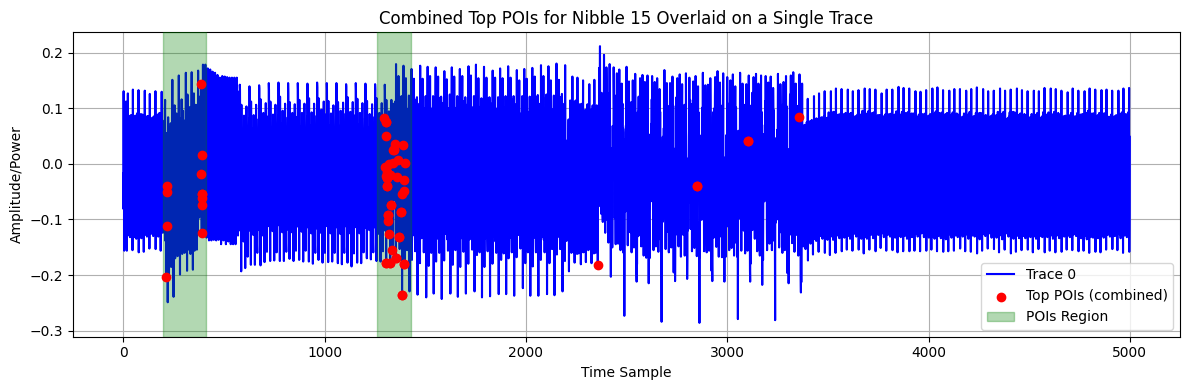

In [33]:
poi_indices = []
nibble_idx = 15

snr_top = np.argsort(results_present[nibble_idx]['snr'])[-25:]
hw_top = np.argsort(results_present[nibble_idx]['correlation'])[-40:]

poi_indices.extend(snr_top)
poi_indices.extend(hw_top)

global_pois.extend(poi_indices)

unique_pois = sorted(set(poi_indices))

# Plot the trace
plt.figure(figsize=(12, 4))
plt.plot(trace, label=f"Trace {trace_index}", color='blue')

# Mark POIs
plt.scatter(poi_indices, trace[poi_indices], color='red', zorder=5, label="Top POIs (combined)")
plt.title(f"Combined Top POIs for Nibble {nibble_idx} Overlaid on a Single Trace")
plt.xlabel("Time Sample")
plt.ylabel("Amplitude/Power")
plt.axvspan(200, 410, color='green', alpha=0.3, label="POIs Region", zorder=3)
plt.axvspan(1260, 1430, color='green', alpha=0.3, zorder=3)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
ranges = {
    "global": [200, 2250],
    "per_nibble": {
        "0": [[500, 700], [2100, 2250]],
        "1": [[520, 720], [2060, 2180]],
        "2": [[520, 760], [2000, 2100]],
        "3": [[300, 550], [680, 800], [1960, 2060]],
        "4": [[300, 550], [750, 870], [1900, 2000]],
        "5": [[300, 550], [800, 900], [1850, 1950]],
        "6": [[280, 530], [850, 950], [1800, 1900]],
        "7": [[270, 520], [900, 1000], [1750, 1850]],
        "8": [[250, 500], [950, 1050], [1700, 1800]],
        "9": [[240, 480], [980, 1100], [1650, 1750]],
        "10": [[240, 480], [1020, 1150], [1580, 1700]],
        "11": [[230, 470], [1070, 1200], [1550, 1650]],
        "12": [[220, 460], [1120, 1220], [1490, 1590]],
        "13": [[210, 440], [1180, 1300], [1420, 1520]],
        "14": [[200, 430], [1230, 1480]],
        "15": [[200, 410], [1260, 1430]],
    }
}
# Save ranges to a JSON
import json
with open("../dataset/present/ranges.json", "w") as f:
    json.dump(ranges, f, indent=4)

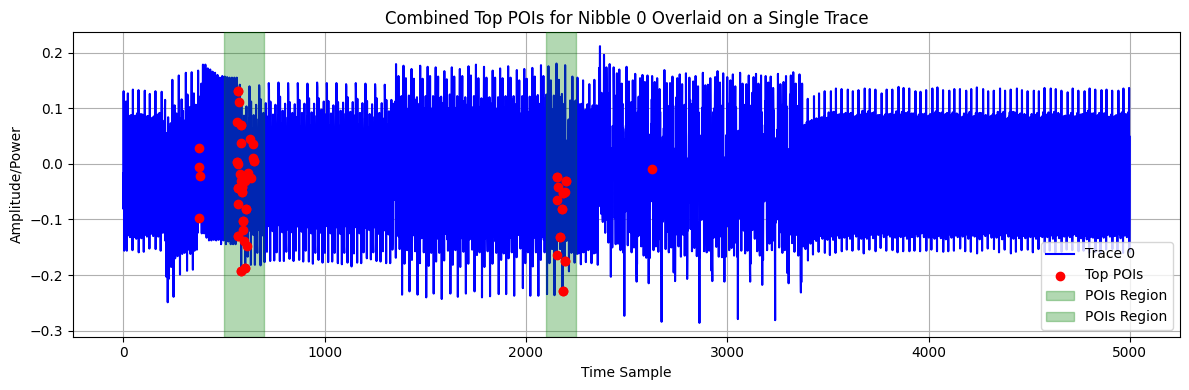

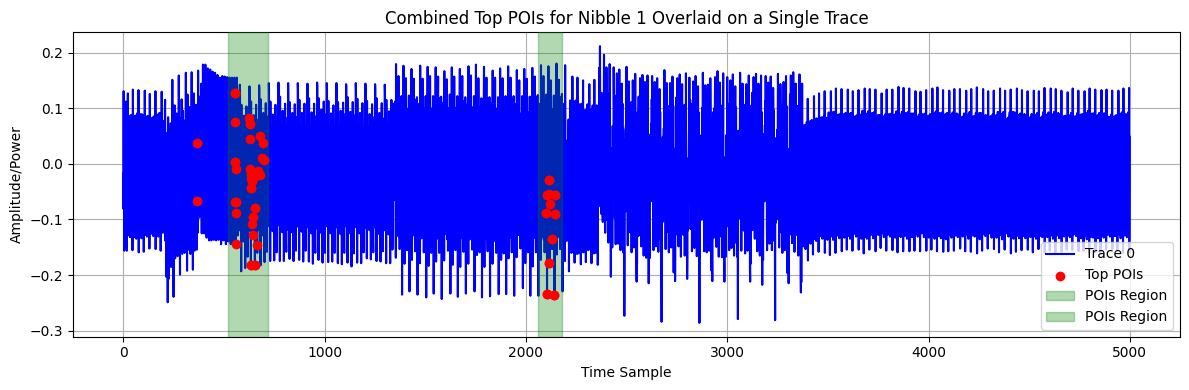

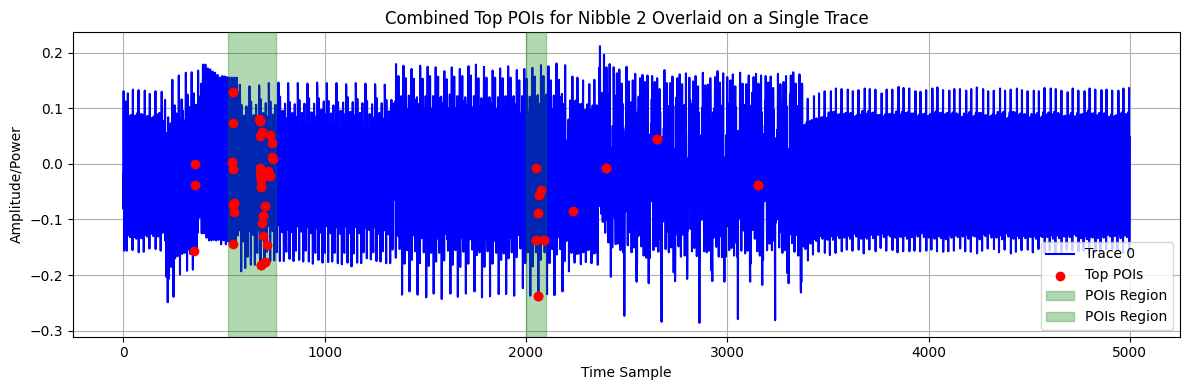

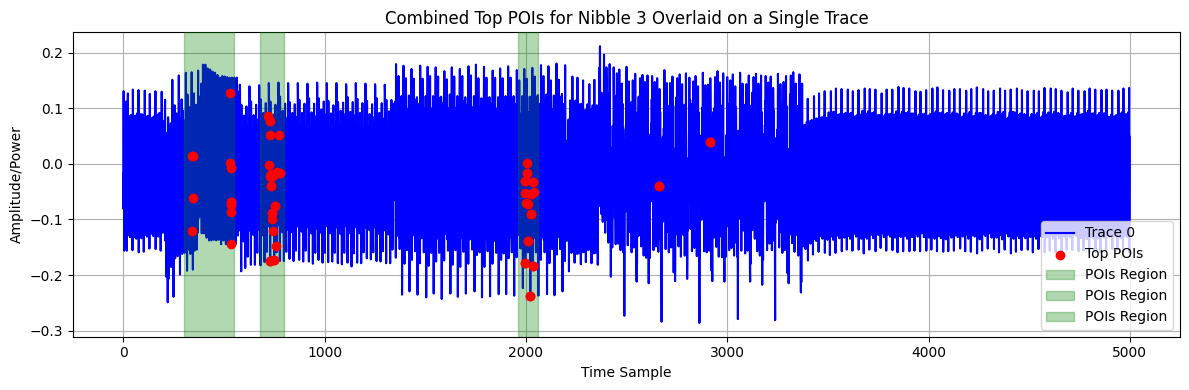

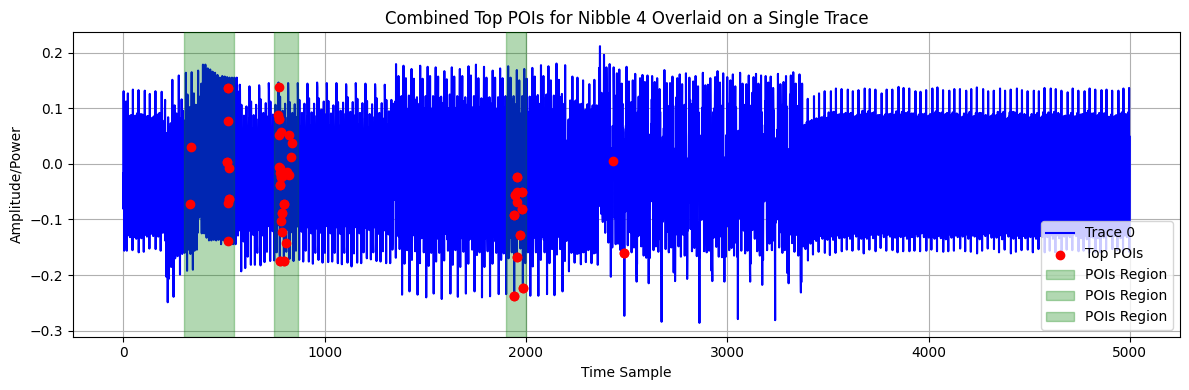

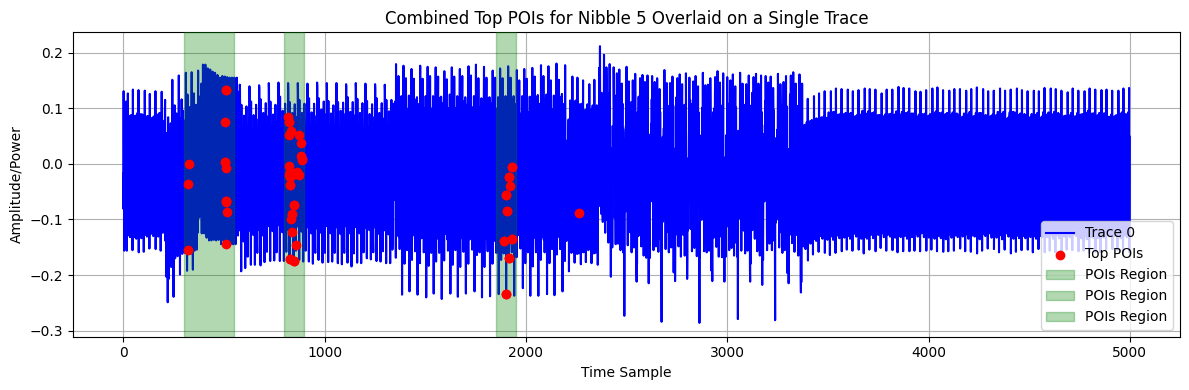

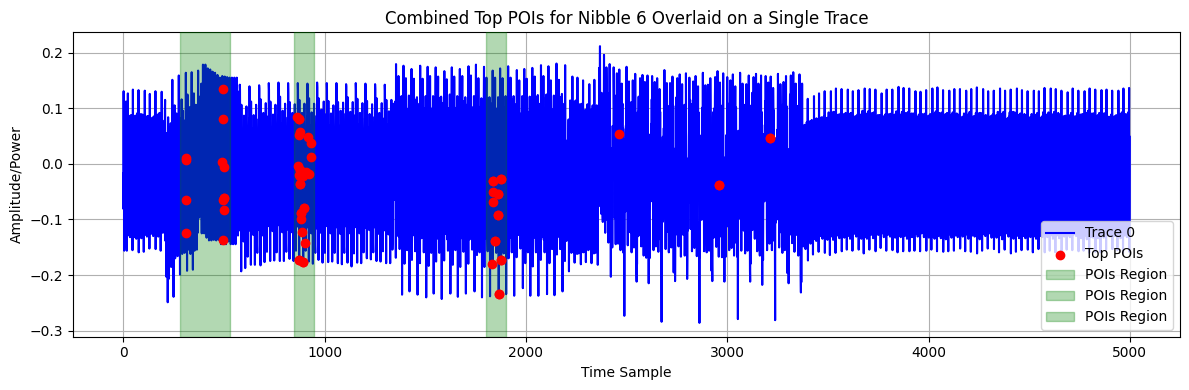

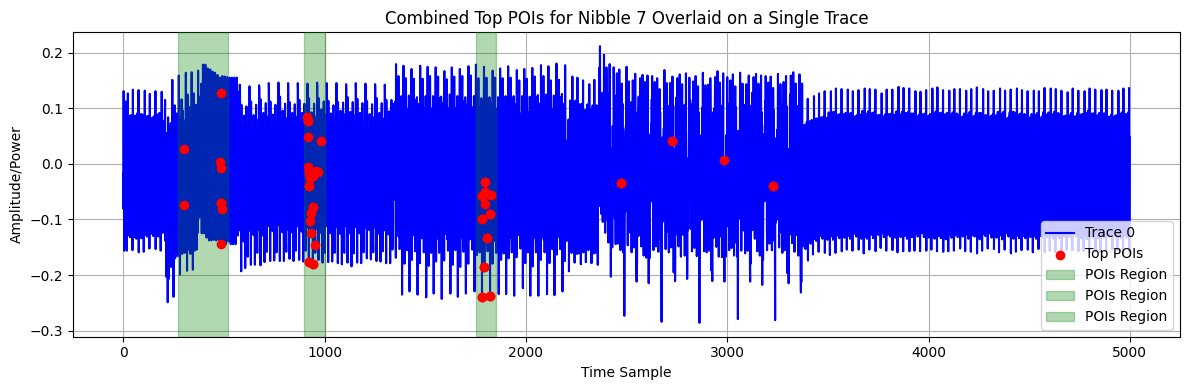

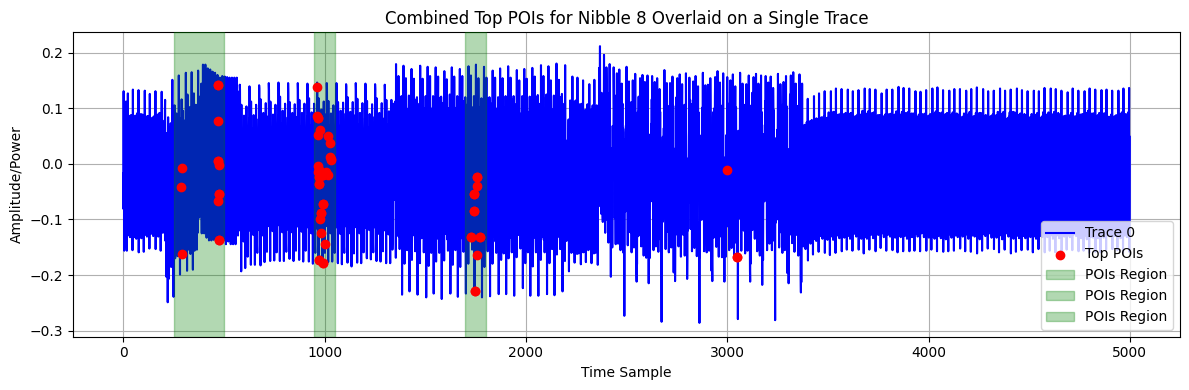

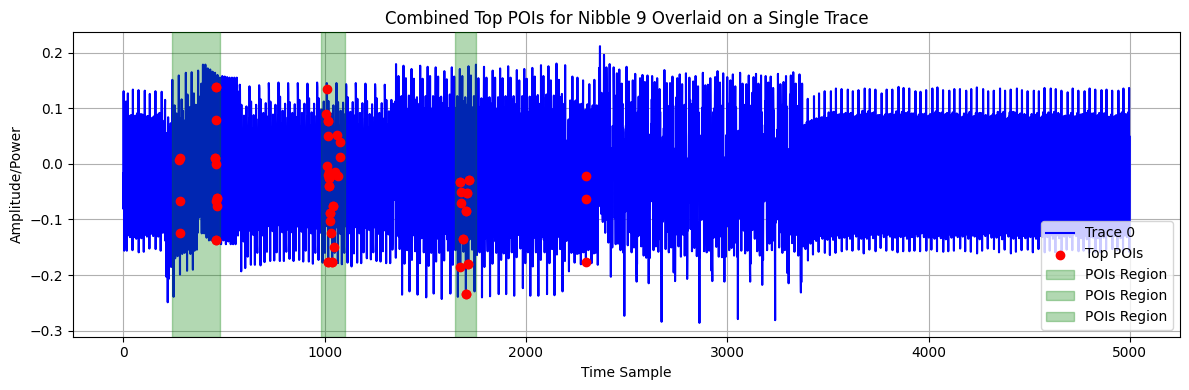

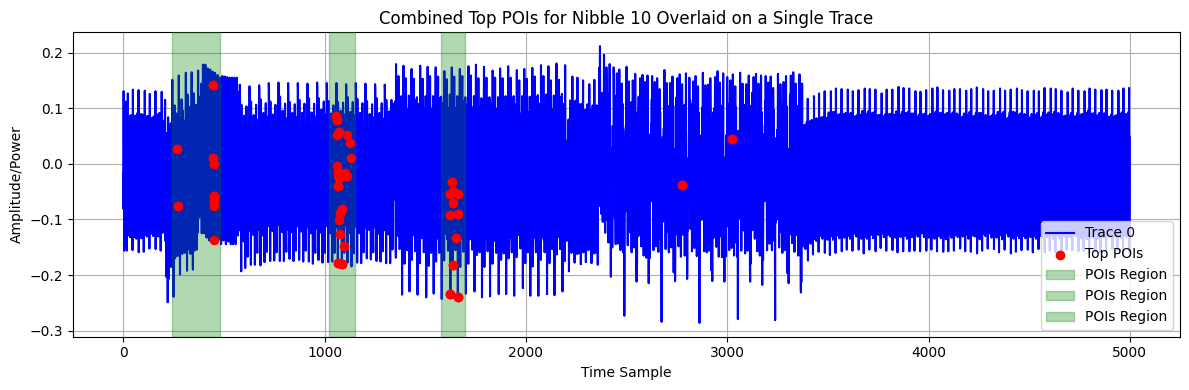

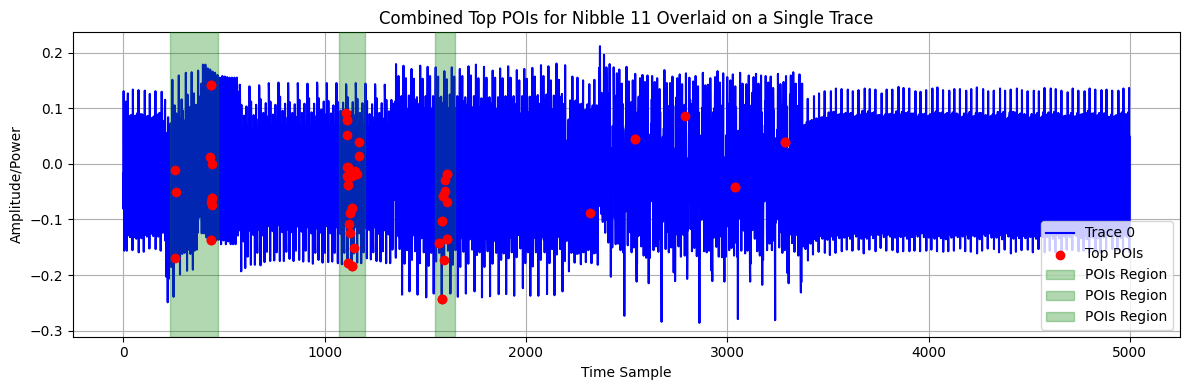

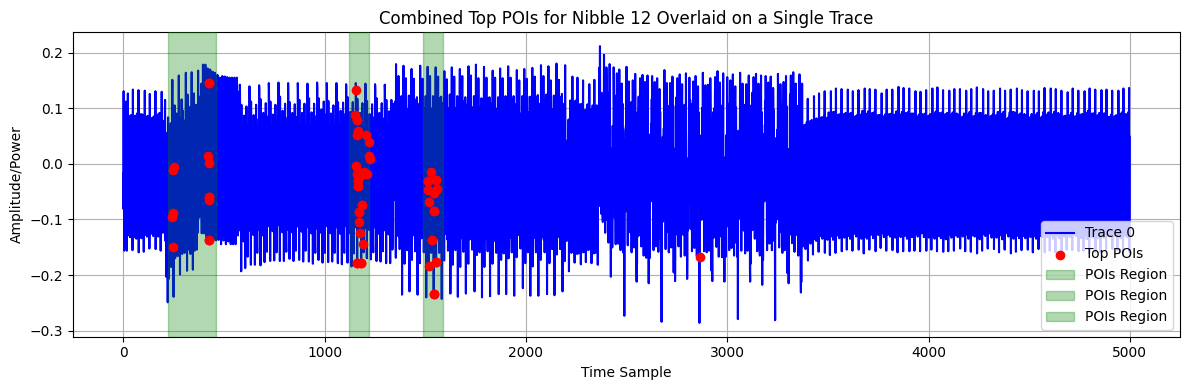

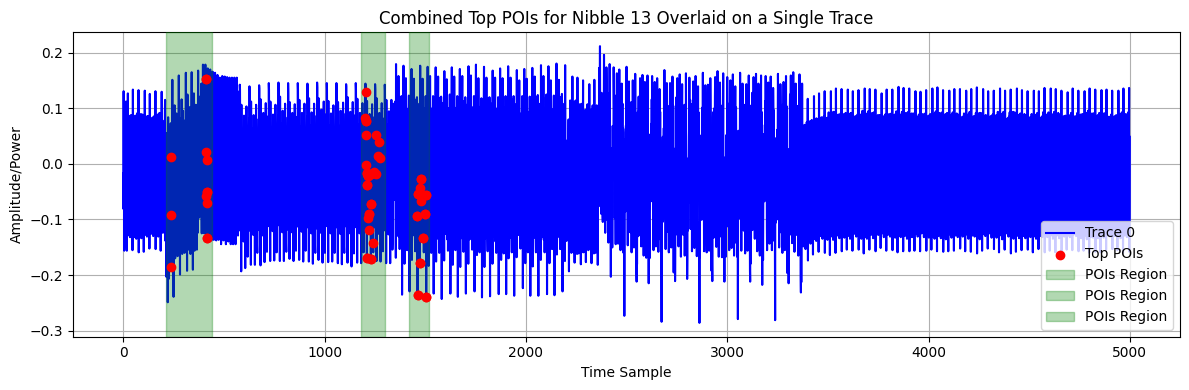

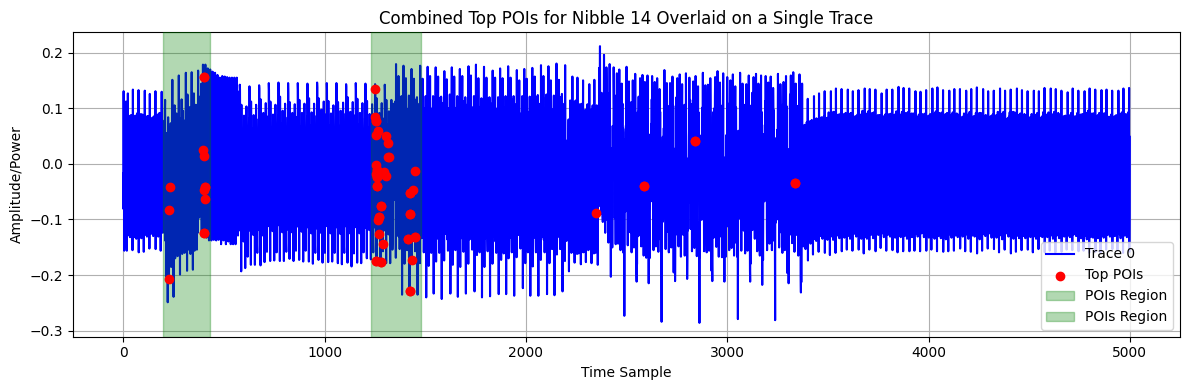

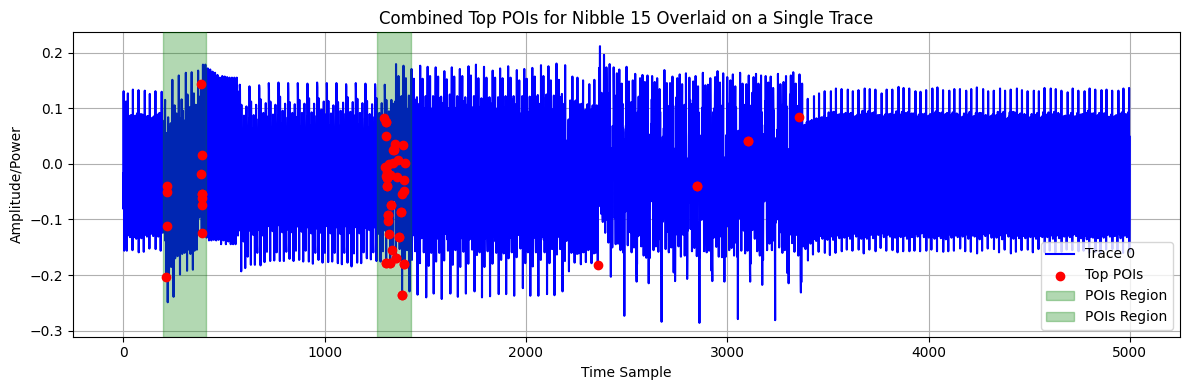

In [35]:
for idx, ranges_list in ranges["per_nibble"].items():
    poi_indices = []
    nibble = int(idx)
    snr_top = np.argsort(results_present[nibble]['snr'])[-25:]
    hw_top = np.argsort(results_present[nibble]['correlation'])[-40:]

    poi_indices.extend(snr_top)
    poi_indices.extend(hw_top)

    global_pois.extend(poi_indices)

    unique_pois = sorted(set(poi_indices))

    # Plot the trace
    plt.figure(figsize=(12, 4))
    plt.plot(trace, label=f"Trace {trace_index}", color='blue')

    # Mark POIs
    plt.scatter(poi_indices, trace[poi_indices], color='red', zorder=5, label="Top POIs")
    plt.title(f"Combined Top POIs for Nibble {nibble} Overlaid on a Single Trace")
    plt.xlabel("Time Sample")
    plt.ylabel("Amplitude/Power")
    for item in enumerate(ranges_list):
        _range = item[1]
        plt.axvspan(_range[0], _range[1], color='green', alpha=0.3, label="POIs Region", zorder=3)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Hypothesis Conclusion
The results from our signal-to-noise ratio (SNR) and Pearson correlation analyses confirm the presence of statistically significant leakage in specific time samples of the power traces. These leakage points correlate strongly with intermediate values of the cipher's internal state, particularly the SBox outputs, thereby validating the hypothesis that side-channel information leakage is detectable and quantifiable in the recorded traces.